In [64]:
import numpy as np
import matplotlib.pylab as plt
from pylab import *
import sys
from fft_utils import fft_1d, shift_1d


In [160]:
e0 = np.loadtxt('837nm.dat')		#load the reference pulse, pump @836 nm
e0 = e0.T
e1 = np.sqrt(e0[1])
e1_ph = e0[2]
e = np.array(e1)*np.exp(-1j*(np.array(e1_ph)))		#reforming E-field

original_trace = np.loadtxt('traces/trace11.frg')		#load FROG trace from experiment
N = len(e0[0])		#timesteps
N_max = np.max(e0[0])
N_min = np.min(e0[0])

t = e0[0]-N_min
T0 = N_max-N_min	#total time duration
dt = T0/(N-1)
df = 1.0/T0		#frequency steps
TD = N			#time delay for FROG-trace generation
freq = np.arange(0,1/dt+df,df)*1000

In [161]:
A = 3.0			#Amplitude of Raman pulse
a = 1.0			#intensity dependent factor ##it is not used in this program, ignore it.
a2 = 2.50*10**-6	#second order phase factor
a3 = 3.0*10**-9		#third order phase factor

f0 = 1.600/1000.0	#Raman center-wavelength
f1 = 0.25/1000.0	#Red-shifted center-wavelength

i0 = 333.0		#unit: fs
tau1 = T0/2+i0-400	#Raman pulse peak time
tau2 = tau1-700		#Red-shifted pulse peak time

In [162]:
def gaussian_pulse(T,f,A,phase,tau):
    w0 = f*2*np.pi		#central angular frequency of pulse
    temp = -1j*w0*(t-tau) + 1j*phase
    E = A*np.sqrt(np.exp(-4.0*np.log(2.0)/np.log(np.e)*((t-tau)/T)**2))*np.exp(-temp)
    return E

In [163]:
def xcorr(e0,e,td):		#shift one pulse by time delay of 'td'
    E_delay = e*1.0
    if td<=0:
        E_delay[0:N+td] = e0[-td:]
        E_delay[N+td:] = [0]*(-td)
        #E_delay=np.roll(e0,td)*([1]*(N+td)+[0]*(-td))
    else:
        E_delay[0:td] = [0]*(td)
        E_delay[td:] = e0[0:N-td]
        #E_delay=np.roll(e0,td)*([0]*(td)+[1]*(N-td))
    return  e*E_delay

In [164]:
def FROG_generator(e,E,TD):
    FROG = np.zeros((TD,N), dtype=np.float64)
    for td in range(-TD//2,TD//2):
        E_corre = xcorr(e,E,td)
        temp0 =np.fft.fftshift(np.fft.fft(E_corre))
        FROG[(td+TD//2)-1] = np.abs(temp0)**2
    return FROG.T

In [165]:
def array_difference(A,B):
    A = A/np.max(A)
    B = B/np.max(B)
    return np.sum(np.square(A-B))/np.sum(np.square(A))

In [166]:
def FROGs(t1,t2,i0,A,f0,a,a2,a3, f1, tau1, tau2): 
    phase1 = a2*np.power(t-tau1,2)+a3*np.power(t-tau1,3)
    phase2 = a2*(t-tau2)**2+a3*(t-tau2)**3
    E1 = gaussian_pulse(t1,f0,A,phase1,tau1)
    E2 = gaussian_pulse(t2,f1,a,phase2 - math.pi,tau2)
    E = E1+E2
    FROG = FROG_generator(e,E,TD)
    delta = array_difference(FROG, original_trace)
    return FROG, delta

In [167]:
def FROG_trace_plot(FROG):
    fig,ax = plt.subplots()
    plt.imshow(FROG)
    plt.title("FROG trace")
    plt.grid(True)
    plt.show()

In [168]:
def grads(T,i0, A, f0,a, a2, a3, f1, tau1, tau2):
    grad=np.zeros(8)
    epsilon=1e-9
    grad[0]=(FROGs(T+epsilon,T+epsilon,i0,A,f0,a,a2,a3,f1, tau1,tau2)[1]-FROGs(T-epsilon,T-epsilon,i0,A,f0,a,a2,a3, f1, tau1,tau2)[1])/(2*epsilon)
    grad[1]=(FROGs(T,T,i0,A+epsilon,f0,a,a2,a3,f1, tau1,tau2)[1]-FROGs(T,T,i0,A-epsilon,f0,a,a2,a3, f1, tau1,tau2)[1])/(2*epsilon)
    grad[2]=(FROGs(T,T,i0,A,f0+epsilon,a,a2,a3,f1, tau1,tau2)[1]-FROGs(T,T,i0,A,f0-epsilon,a,a2,a3, f1, tau1,tau2)[1])/(2*epsilon)
    grad[3]=(FROGs(T,T,i0,A,f0,a,a2+epsilon,a3,f1, tau1,tau2)[1]-FROGs(T,T,i0,A,f0,a,a2-epsilon,a3, f1, tau1,tau2)[1])/(2*epsilon)
    grad[4]=(FROGs(T,T,i0,A,f0,a,a2,a3+epsilon*(10**-6),f1, tau1,tau2)[1]-FROGs(T,T,i0,A,f0,a,a2,a3-epsilon*(10**-6), f1, tau1,tau2)[1])/(2*epsilon*(10**-6))
    grad[5]=(FROGs(T,T,i0,A,f0,a,a2,a3, f1 + epsilon, tau1,tau2)[1]-FROGs(T,T,i0,A,f0,a,a2,a3, f1-epsilon, tau1,tau2)[1])/(2*epsilon)
    grad[6]=(FROGs(T,T,i0,A,f0,a,a2,a3, f1,tau1 + epsilon,tau2)[1]-FROGs(T,T,i0,A,f0,a,a2,a3, f1,tau1-epsilon,tau2)[1])/(2*epsilon)
    grad[7]=(FROGs(T,T,i0,A,f0,a,a2,a3, f1,tau1,epsilon+tau2)[1]-FROGs(T,T,i0,A,f0,a,a2,a3, f1,tau1, tau2-epsilon)[1])/(2*epsilon)
    return grad

In [169]:
def gradient_d(T, i0, A, f0, a, a2, a3, f1, tau1, tau2):
    learning_rate=np.array([10000,.05, 1e-7, 5e-13, 1e-16, 1e-9, 50000,50000])
    epochs=2000
    cost=[]
    min_delta = 1
    for i in range(epochs):
        if(i==500):
            learning_rate[0]=5000
            learning_rate[3] = 1e-13
        grad = grads(T,i0,A,f0,a,a2,a3 ,f1,tau1, tau2)
        T = T - learning_rate[0]*grad[0]
        A = A - learning_rate[1]*grad[1]
        f0 = f0 - learning_rate[2]*grad[2]
        a2 = a2 - learning_rate[3]*grad[3]
        a3 = a3 - learning_rate[4]*grad[4]
        f1 = f1 - learning_rate[5]*grad[5]
        tau1 = tau1 - learning_rate[6]*grad[6]
        tau2 = tau2 - learning_rate[7]*grad[7]
        if(f1 < 0):
            f1 = f1 + 0.9*learning_rate[5]*grad[5]
            learning_rate[5] /=10
        if(T < 0):
            T = T +0.9*learning_rate[0]*grad[0]
            learning_rate[0]/=10
        if(A<0):
            A = A +0.9*learning_rate[2]*grad[2]
            learning_rate[2]/=2
        (FROG, delta) = FROGs(T,T,i0,A,f0,a,a2,a3,f1, tau1, tau2) 
        print(i, delta, T, f1, grad[0])
        if(delta < min_delta and f1>0 and T>0 and A>0):
            min_delta = delta
            min_par = np.array([T, A, f0, a2, a3, f1, tau1, tau2])
            min_frog = FROG
        cost.append(delta)
    
    #print("delta = ", min_delta,"\nT =", min_par[0], "\nA =" , min_par[1],"\nf0 =",min_par[2],"\na =", 1, "\na2 =", min_par[3],"\na3 =", min_par[4],"\nf1 =", min_par[5],"\ntau1 =",min_par[6],"\ntau2 =", min_par[7])
    plt.plot(list(range(epochs)), cost, '-r') 
    plt.xlabel('Epochs') 
    plt.ylabel('Delta')
    FROG_trace_plot(min_frog)
    return min_par

1000 3150 2450
0 0.8480894894183347 998.8045673582349 0.00027317381675961267 0.00011954326417651372
1 0.6795964638751065 998.2050469249373 0.0002713812089601903 5.9952043329758446e-05
2 0.5562946501550728 997.9224951651702 0.0002706277095720839 2.825517597671023e-05
3 0.6123024802831935 1000.5159761506945 0.0002695496572027096 -0.00025934809855243657
4 0.5265247226847083 998.0918041764255 0.0002698427658769859 0.0002424171974269029
5 0.46655538491688286 995.4333751439606 0.000270153402391164 0.00026584290324649373
6 0.41148038009630494 992.7913219011089 0.00027032403789144905 0.00026420532428517163
7 0.38145355169089645 989.7359881373404 0.00027080713961943176 0.0003055333763768431
8 0.3571685553829737 987.1533318263062 0.00027105548968744237 0.00025826563110342704
9 0.33427615578381187 984.6411746773356 0.0002712607223490022 0.0002512157148970573
10 0.31697388428191214 982.2561380646846 0.0002714194226328332 0.00023850366126509923
11 0.29923773042744034 979.5674554547986 0.00027174999

96 0.12018442821220099 908.1828905289632 0.00026950651669644505 5.197231534026514e-05
97 0.12013763742674477 907.6654572105488 0.0002694633682095713 5.17433318414362e-05
98 0.12009127382278233 907.1503831160617 0.0002694202007089625 5.1507409448703356e-05
99 0.12004531692825017 906.6375294676238 0.00026937701479544363 5.1285364843778325e-05
100 0.11999976887384041 906.1271738209914 0.0002693338124809192 5.1035564663237665e-05
101 0.11995461942569528 905.6192467872254 0.0002692905950713723 5.079270337660091e-05
102 0.11990986486033228 905.1138871442038 0.0002692473633728041 5.0535964302156344e-05
103 0.1198654766833486 904.6106785582924 0.00026920411768940867 5.032085859113522e-05
104 0.11982146349167089 904.1099679741865 0.00026916085880381 5.007105841059456e-05
105 0.11977779326456674 903.6112696693126 0.00026911758688839805 4.986983048738125e-05
106 0.11973448072990715 903.1149999773052 0.00026907430410445777 4.96269692007445e-05
107 0.11969151697099349 902.621089509225 0.00026903101

192 0.1170134405844514 868.3281737799082 0.0002653387985588199 3.2279734440976426e-05
193 0.1169910431129761 868.0069723810964 0.0002652952540739895 3.212013988118656e-05
194 0.11696881280152878 867.6875057057605 0.0002652517068577607 3.194666753358888e-05
195 0.11694675042063922 867.3698431428396 0.0002652081562561149 3.176625629208729e-05
196 0.11692485681751018 867.0540540812729 0.0002651646029501601 3.1578906156681796e-05
197 0.11690311763455172 866.7397221874259 0.00026512104796575626 3.1433189384699745e-05
198 0.11688154551236841 866.427263794933 0.00026507749136639425 3.124583924929425e-05
199 0.11686013052798042 866.1164013480379 0.00026503393108432533 3.108624468950438e-05
200 0.11683887331136525 865.8072042356798 0.00026499036719891656 3.091971123581061e-05
201 0.11681777692839096 865.4998112357367 0.00026494680079149047 3.073929999430902e-05
202 0.11679683883444282 865.1941529592696 0.0002649032319044992 3.056582764671134e-05
203 0.11677605688860304 864.8902294062784 0.00026

288 0.11545910534021472 844.5605886576726 0.00026115043033719094 1.8263168755083825e-05
289 0.11544772837660908 844.3792753599635 0.000261106790987786 1.8131329770909588e-05
290 0.11543642590426201 844.199211063157 0.00026106315318556706 1.8006429680639258e-05
291 0.11542519278649278 844.0202569893752 0.0002610195164405094 1.7895407378176742e-05
292 0.11541402643812845 843.8422049718009 0.0002609758828478676 1.7805201757425948e-05
293 0.11540293388927655 843.6654713440685 0.0002609322513330984 1.767336277325171e-05
294 0.11539191292915711 843.4899867172387 0.00026088862078881675 1.754846268298138e-05
295 0.11538096177934522 843.3156817023726 0.00026084499208331425 1.7430501486614958e-05
296 0.115370075697543 843.142348132653 0.0002608013657598438 1.7333356971960256e-05
297 0.11535925693233462 842.970124785958 0.0002607577419592303 1.722233466949774e-05
298 0.1153485121156999 842.7994279959219 0.00026071412075585865 1.7069679003611782e-05
299 0.11533782812118404 842.6294944842152 0.0002

383 0.11462637398629207 831.9404753699421 0.00025702110108952853 9.083012120214562e-06
384 0.11461959632794165 831.8504085270694 0.00025697790418179717 9.006684287271582e-06
385 0.11461284608514283 831.76082740677 0.0002569347149415436 8.958112029944232e-06
386 0.11460612961961648 831.6724258984342 0.00025689153354312134 8.840150833577809e-06
387 0.11459944063547582 831.5845795016107 0.00025684835914022825 8.784639682346551e-06
388 0.11459277984271632 831.4974269941777 0.00025680519276020226 8.715250743307479e-06
389 0.1145861491755293 831.411176542952 0.00025676203344174287 8.625045122556685e-06
390 0.11457954422089037 831.3253424253608 0.00025671888153105233 8.583411759133242e-06
391 0.11457296933568539 831.2404797529159 0.0002566757378665294 8.48626724447854e-06
392 0.11456642157930547 831.1563109698616 0.00025663260294303525 8.416878305439468e-06
393 0.11455990156961215 831.0728360761975 0.00025658947602288907 8.347489366400396e-06
394 0.11455340917937352 830.990055071924 0.0002565

479 0.11407914547730107 826.2437822527135 0.00025291489840096443 3.316791286067655e-06
480 0.11407426408724324 826.2109612845479 0.00025287261912460674 3.282096816548119e-06
481 0.11406939536854309 826.1786260389557 0.00025283035216946254 3.2335245592207684e-06
482 0.11406453898505362 826.1469152938148 0.00025278809659940566 3.1710745140856034e-06
483 0.11405969509826806 826.1156208823081 0.0002527458529203439 3.12944115066216e-06
484 0.11405486272610231 826.0847428044358 0.00025270362081267184 3.0878077872387166e-06
485 0.11405004195151447 826.0542116712586 0.00025266140099946383 3.0531133177191805e-06
486 0.11404523350942403 826.0242356495937 0.00025261919247412923 2.9976021664879227e-06
487 0.11404043622968822 825.9946759615631 0.0002525769946195922 2.9559688030644793e-06
488 0.11403565097966968 825.9656019961058 0.0002525348089462418 2.9073965457371287e-06
489 0.11403087750229532 825.9371525310997 0.00025249263498081076 2.8449465006019636e-06
490 0.11402611568996236 825.90925817760

576 0.11377568445035667 825.2441305024471 0.00024888600397237454 3.400058012914542e-07
577 0.11377319761371882 825.2424998623796 0.00024884503830946403 3.2612801348363973e-07
578 0.11377071328809547 825.2410080001903 0.0002488040810922213 2.983724378680108e-07
579 0.11376823158561022 825.2394467490619 0.0002487631320950837 3.122502256758253e-07
580 0.1137657522354348 825.2379548868726 0.0002487221919213465 2.983724378680108e-07
581 0.1137632751813351 825.2366018025613 0.00024868125995855506 2.706168622523819e-07
582 0.11376080063791433 825.2352834127196 0.00024864033563895527 2.636779683484747e-07
583 0.11375832827731684 825.2340691062864 0.0002485994195835573 2.42861286636753e-07
584 0.11375585841976171 825.2329241887923 0.00024855851123325285 2.289834988289385e-07
585 0.1137533908651387 825.2318139657676 0.00024851761138006806 2.2204460492503128e-07
586 0.11375092535535493 825.2308078261516 0.0002484767202666075 2.0122792321330962e-07
587 0.11374846224693548 825.2297669920661 0.00024

673 0.11354246849167247 825.3017233218493 0.00024494743887227394 -4.4408920985006256e-07
674 0.1135401263321832 825.3038743789594 0.00024490716933259194 -4.302114220422481e-07
675 0.11353778519959629 825.3060948250087 0.00024486690603211353 -4.4408920985006256e-07
676 0.11353544514140805 825.3083499655274 0.000244826648779353 -4.510281037539698e-07
677 0.11353310598653238 825.3107091894548 0.0002447863990474514 -4.718447854656915e-07
678 0.11353076808800895 825.3129643299735 0.0002447461554761427 -4.510281037539698e-07
679 0.1135284310030262 825.3153582483703 0.0002447059187038814 -4.787836793695988e-07
680 0.11352609492267553 825.3177174722977 0.0002446656874923942 -4.718447854656915e-07
681 0.11352375995768742 825.3201113906945 0.0002446254615270577 -4.787836793695988e-07
682 0.11352142602165989 825.3225053090913 0.0002445852428542628 -4.787836793695988e-07
683 0.11351909308656954 825.3248645330186 0.0002445450307685807 -4.718447854656915e-07
684 0.1135167611507491 825.327293145885 0

768 0.11332434631162744 825.5927405321789 0.00024114912918759396 -7.424616477180734e-07
769 0.11332209553402355 825.596556923826 0.00024110943388481998 -7.632783294297951e-07
770 0.11331984565576222 825.6003733154732 0.00024106974332831882 -7.632783294297951e-07
771 0.11331759671481628 825.6041550126508 0.00024103005803415684 -7.563394355258879e-07
772 0.11331534863187909 825.6080060987675 0.0002409903783352136 -7.702172233337023e-07
773 0.11331310155923968 825.6117531014756 0.00024095070454640383 -7.494005416219807e-07
774 0.11331085535385373 825.6155694931228 0.00024091103632802708 -7.632783294297951e-07
775 0.11330861003638602 825.6194205792395 0.00024087137503251538 -7.702172233337023e-07
776 0.11330636560966624 825.6232369708866 0.0002408317195409166 -7.632783294297951e-07
777 0.11330412195289075 825.6270880570033 0.00024079206999992587 -7.702172233337023e-07
778 0.11330187937808027 825.6309738375895 0.0002407524269852216 -7.771561172376096e-07
779 0.11329963786718024 825.63475553

863 0.11311451892283092 825.9991862425993 0.00023740405771039536 -9.506284648352902e-07
864 0.11311235245268839 826.003904690454 0.00023736491330871696 -9.43689570931383e-07
865 0.1131101868780612 826.0086231383086 0.00023732577564895808 -9.43689570931383e-07
866 0.11310802217309517 826.0133068916938 0.00023728664435675845 -9.367506770274757e-07
867 0.1131058582512505 826.0180947284875 0.0002372475192660981 -9.575673587391975e-07
868 0.11310369524167486 826.0227784818727 0.00023720839869795902 -9.367506770274757e-07
869 0.11310153308795569 826.0274969297274 0.00023716928425628037 -9.43689570931383e-07
870 0.11309937159117403 826.0323194609906 0.00023713017526277836 -9.645062526431047e-07
871 0.11309721111038042 826.0371072977844 0.00023709107215089792 -9.575673587391975e-07
872 0.11309505133175535 826.0419645235171 0.0002370519751071149 -9.71445146547012e-07
873 0.11309289237600273 826.0468911381888 0.00023701288465299126 -9.853229343548264e-07
874 0.11309073435646176 826.051783058391 

958 0.11291247608623875 826.4832781758055 0.00023371132167208908 -1.096345236817342e-06
959 0.11291038936982845 826.4886211241114 0.00023367272850094412 -1.0685896612017132e-06
960 0.11290830323563297 826.4941028502956 0.00023363414128808164 -1.096345236817342e-06
961 0.1129062179985684 826.4996192709492 0.00023359556008054733 -1.1032841307212493e-06
962 0.11290413365899664 826.5050316081943 0.00023355698565481037 -1.0824674490095276e-06
963 0.11290205002756462 826.5104439454393 0.0002335184163523849 -1.0824674490095276e-06
964 0.11289996712489948 826.5158909771538 0.0002334798528536642 -1.0894063429134349e-06
965 0.11289788510576608 826.5213727033379 0.00023344129489006444 -1.096345236817342e-06
966 0.11289580397802487 826.5267850405829 0.00023340274336586231 -1.0824674490095276e-06
967 0.1128937236113252 826.5321626833585 0.00023336419677191084 -1.0755285551056204e-06
968 0.11289164400703412 826.5377137984816 0.00023332565527121158 -1.1102230246251565e-06
969 0.11288956520199889 826.

1052 0.1127198188674771 827.0177117842842 0.00023010872597543203 -1.1934897514720433e-06
1053 0.11271780683261429 827.0236098441026 0.00023007067421109534 -1.1796119636642288e-06
1054 0.11271579541624842 827.0296119873294 0.00023003262825815863 -1.2004286453759505e-06
1055 0.11271378489786966 827.0355447416173 0.00022999458770667897 -1.186550857568136e-06
1056 0.11271177508152569 827.0414774959052 0.00022995655264965837 -1.186550857568136e-06
1057 0.11270976607559924 827.0474449446625 0.0002299185226628806 -1.1934897514720433e-06
1058 0.11270775778298155 827.0534123934199 0.00022988049764637703 -1.1934897514720433e-06
1059 0.11270575048514708 827.0593798421772 0.00022984247946024306 -1.1934897514720433e-06
1060 0.11270374379396608 827.0653125964651 0.00022980446781317005 -1.186550857568136e-06
1061 0.11270173764409677 827.071384128631 0.00022976646140407376 -1.214306433183765e-06
1062 0.11269973243643153 827.077455660797 0.00022972846074556497 -1.214306433183765e-06
1063 0.112697728043

1145 0.11253595359915038 827.5905174760514 0.00022659429132242787 -1.2559397966072083e-06
1146 0.11253401171358066 827.596901258443 0.00022655676774031137 -1.27675647831893e-06
1147 0.11253207052962648 827.6032850408346 0.00022651925008697316 -1.27675647831893e-06
1148 0.11253012999286205 827.6097382121652 0.0002264817383236179 -1.2906342661267445e-06
1149 0.11252819040908713 827.6160873000873 0.00022644423207913967 -1.2698175844150228e-06
1150 0.11252625144035505 827.622540471418 0.0002264067310100077 -1.2906342661267445e-06
1151 0.11252431339588986 827.6288548648706 0.0002263692362148293 -1.2628786905111156e-06
1152 0.112522375834469 827.6352733417317 0.00022633174726847233 -1.2836953722228372e-06
1153 0.11252043930440479 827.6415530407147 0.00022629426414817028 -1.2559397966072083e-06
1154 0.1125185034775538 827.6479715175758 0.000226256785782322 -1.2836953722228372e-06
1155 0.11251656832656619 827.6543206054979 0.00022621931374966465 -1.2698175844150228e-06
1156 0.11251463355418943

1238 0.11235845711347105 828.1980523318082 0.00022312868528911295 -1.3461454173580023e-06
1239 0.11235658201512218 828.2047830588949 0.00022309168375245192 -1.3461454173580023e-06
1240 0.11235470750892051 828.2114790915122 0.0002230546870978995 -1.339206523454095e-06
1241 0.11235283372308731 828.2182445130685 0.000223017695250814 -1.3530843112619095e-06
1242 0.11235096074647802 828.2249405456857 0.00022298070837382922 -1.339206523454095e-06
1243 0.1123490884842199 828.231567189364 0.00022294372728927348 -1.3253287356462806e-06
1244 0.11234721683068896 828.2382285275118 0.00022290675171306846 -1.3322676295501878e-06
1245 0.11234534581367511 828.2449939490681 0.0002228697817094475 -1.3530843112619095e-06
1246 0.11234347569449118 828.2516205927463 0.00022283281742053996 -1.3253287356462806e-06
1247 0.11234160631641113 828.2583513198331 0.00022279585950982206 -1.3461454173580023e-06
1248 0.11233973753650091 828.2650126579808 0.0002227589080184137 -1.3322676295501878e-06
1249 0.112337869313

1331 0.11218701595559845 828.8311917060703 0.00021971104026295685 -1.3877787807814457e-06
1332 0.11218520433527181 828.8380959055047 0.00021967454945056425 -1.3808398868775384e-06
1333 0.11218339335535141 828.8450347994086 0.00021963806432990346 -1.3877787807814457e-06
1334 0.11218158302274922 828.8519736933125 0.00021960158409956 -1.3877787807814457e-06
1335 0.11217977354780514 828.8588431982773 0.00021956510969374488 -1.3739009929736312e-06
1336 0.11217796447772177 828.8658514811202 0.00021952863982933175 -1.4016565685892601e-06
1337 0.11217615618851004 828.8727556805546 0.00021949217498568713 -1.3808398868775384e-06
1338 0.11217434850432223 828.879659879989 0.000219455715797359 -1.3808398868775384e-06
1339 0.11217254148776758 828.8865640794235 0.00021941926144555097 -1.3808398868775384e-06
1340 0.1121707352125905 828.8934335843883 0.00021938281253731907 -1.3739009929736312e-06
1341 0.11216892959953347 828.9004071727617 0.0002193463688438394 -1.394717674685353e-06
1342 0.112167124838

1425 0.11201957905623067 829.49264176746 0.0002163043393409237 -1.4155343563970746e-06
1426 0.11201782831580194 829.499788828181 0.0002162683532373822 -1.429412144204889e-06
1427 0.11201607810377735 829.506935888902 0.0002162323722238802 -1.429412144204889e-06
1428 0.11201432862618502 829.5140829496231 0.00021619639569771926 -1.429412144204889e-06
1429 0.11201257988544547 829.5211953158746 0.00021616042366553296 -1.4224732503009818e-06
1430 0.11201083169867565 829.5283076821261 0.00021612445681830328 -1.4224732503009818e-06
1431 0.11200908411819852 829.5355241317861 0.0002160884950063236 -1.4432899320127035e-06
1432 0.11200733733999271 829.5426018035681 0.0002160525384547402 -1.4155343563970746e-06
1433 0.11200559104933824 829.5497835587587 0.0002160165882797991 -1.4363510381087963e-06
1434 0.11200384532591588 829.5569306194798 0.00021598064313944182 -1.429412144204889e-06
1435 0.11200210055906709 829.5640429857312 0.00021594470317157894 -1.4224732503009818e-06
1436 0.1120003562319166 

1517 0.11186111877163034 830.1543693846065 0.00021301535262948485 -1.4641066137244252e-06
1518 0.11185942476650713 830.1616552232056 0.00021297984281864308 -1.457167719820518e-06
1519 0.11185773138765628 830.1689063673351 0.00021294433808796676 -1.4502288259166107e-06
1520 0.11185603843442006 830.1762269004038 0.0002129088378512512 -1.4641066137244252e-06
1521 0.1118543462364009 830.1835474334724 0.00021287334230384015 -1.4641066137244252e-06
1522 0.11185265456813634 830.1909373554801 0.00021283785249193144 -1.4779844015322396e-06
1523 0.11185096371348323 830.1981191106706 0.0002128023687807607 -1.4363510381087963e-06
1524 0.11184927337336537 830.2053702548002 0.00021276689052904924 -1.4502288259166107e-06
1525 0.11184758362000546 830.2126213989297 0.00021273141714214772 -1.4502288259166107e-06
1526 0.11184589439950725 830.2198378485898 0.00021269594921814717 -1.4432899320127035e-06
1527 0.11184420586068317 830.2271236871889 0.00021266048583150322 -1.457167719820518e-06
1528 0.11184251

1609 0.11170774934761739 830.8262971757913 0.00020976970065637152 -1.4710455076283324e-06
1610 0.11170610931007645 830.83361770886 0.00020973465462623803 -1.4641066137244252e-06
1611 0.11170446981049618 830.8409382419286 0.00020969961314257885 -1.4641066137244252e-06
1612 0.11170283093275608 830.8482934694667 0.00020966457638295333 -1.4710455076283324e-06
1613 0.11170119271580521 830.8556486970049 0.00020962954430261255 -1.4710455076283324e-06
1614 0.11169955503827679 830.863003924543 0.00020959451856698125 -1.4710455076283324e-06
1615 0.11169791809496882 830.8702550686726 0.00020955949807344837 -1.4502288259166107e-06
1616 0.11169628142437799 830.8776102962107 0.00020952448285119197 -1.4710455076283324e-06
1617 0.11169464531705824 830.8849655237489 0.00020948947155667564 -1.4710455076283324e-06
1618 0.11169300970310655 830.8922860568175 0.0002094544649905853 -1.4641066137244252e-06
1619 0.11169137475900115 830.8996759788251 0.00020941946226554048 -1.4779844015322396e-06
1620 0.1116897

1701 0.11155922212543563 831.5039495544469 0.000206565991856991 -1.491862189340054e-06
1702 0.11155763336191521 831.5113394764545 0.00020653139359998163 -1.4779844015322396e-06
1703 0.11155604516571238 831.5186947039927 0.00020649679962238938 -1.4710455076283324e-06
1704 0.11155445753225178 831.5260152370613 0.00020646221026743273 -1.4641066137244252e-06
1705 0.11155287040829859 831.5334398535385 0.00020642762562595568 -1.4849232954361469e-06
1706 0.11155128376130148 831.5408297755462 0.0002063930449894833 -1.4779844015322396e-06
1707 0.11154969791332502 831.5481156141452 0.00020635846903153932 -1.457167719820518e-06
1708 0.11154811253066053 831.5555055361529 0.0002063238986381164 -1.4779844015322396e-06
1709 0.11154652764506152 831.5628954581605 0.00020628933270944844 -1.4779844015322396e-06
1710 0.11154494350203478 831.5701812967595 0.00020625477175201224 -1.457167719820518e-06
1711 0.11154335981348923 831.5775018298282 0.0002062202156719662 -1.4641066137244252e-06
1712 0.11154177677

1794 0.1114137610865277 832.1906918841171 0.00020336846218870614 -1.4849232954361469e-06
1795 0.11141222174167358 832.1980124171857 0.0002033342984145909 -1.4641066137244252e-06
1796 0.11141068289832694 832.2053676447239 0.000203300139522952 -1.4710455076283324e-06
1797 0.11140914433669728 832.2128269556706 0.00020326598500352406 -1.491862189340054e-06
1798 0.11140760639167852 832.2202515721478 0.00020323183488207808 -1.4849232954361469e-06
1799 0.1114060690884593 832.227606799686 0.0002031976889383042 -1.4710455076283324e-06
1800 0.11140453229626557 832.2349967216936 0.00020316354719516322 -1.4779844015322396e-06
1801 0.11140299601050009 832.2423519492318 0.00020312941081431619 -1.4710455076283324e-06
1802 0.11140146009223892 832.249776565709 0.00020309527870300526 -1.4849232954361469e-06
1803 0.11139992475444152 832.2571664877166 0.00020306115087880667 -1.4779844015322396e-06
1804 0.11139838981856973 832.2646604931329 0.0002030270271093299 -1.4988010832439613e-06
1805 0.1113968553531

1887 0.11127276739449005 832.877815852952 0.00020021055570867258 -1.4779844015322396e-06
1888 0.11127127488191459 832.8851363860207 0.00020017681022804052 -1.4641066137244252e-06
1889 0.11126978275086959 832.8925263080283 0.00020014306876114918 -1.4779844015322396e-06
1890 0.11126829108445761 832.8999509245054 0.00020010933119472807 -1.4849232954361469e-06
1891 0.11126679999737368 832.9073408465131 0.00020007559831847883 -1.4779844015322396e-06
1892 0.11126530944053169 832.9146613795817 0.00020004186958205 -1.4641066137244252e-06
1893 0.11126381914461432 832.922085996059 0.00020000814528946926 -1.4849232954361469e-06
1894 0.11126232944657855 832.9294412235971 0.00019997442535839966 -1.4710455076283324e-06
1895 0.1112608401008121 832.9368658400742 0.00019994070941412013 -1.4849232954361469e-06
1896 0.11125935114824079 832.94439453996 0.00019990699731951118 -1.5057399771478686e-06
1897 0.11125786292549854 832.9517150730286 0.000199873289525365 -1.4641066137244252e-06
1898 0.1112563751692

1981 0.11113456384844611 833.5697623530498 0.0001970571155264012 -1.4779844015322396e-06
1982 0.11113311621180529 833.5770481916488 0.00019702376766678165 -1.457167719820518e-06
1983 0.1111316687741115 833.5843687247175 0.00019699042440706588 -1.4641066137244252e-06
1984 0.11113022187832439 833.5916892577861 0.00019695708511798644 -1.4641066137244252e-06
1985 0.1111287754929597 833.5991138742634 0.0001969237500774807 -1.4849232954361469e-06
1986 0.11112732964572429 833.6063650183929 0.00019689041995023227 -1.4502288259166107e-06
1987 0.11112588446599757 833.613581468053 0.00019685709361860738 -1.4432899320127035e-06
1988 0.11112443946831448 833.6209366955911 0.0001968237722763872 -1.4710455076283324e-06
1989 0.11112299513051993 833.6282225341902 0.00019679045563630155 -1.457167719820518e-06
1990 0.11112155119641322 833.6355083727892 0.00019675714302821285 -1.457167719820518e-06
1991 0.11112010767876712 833.6427942113883 0.0001967238351289894 -1.457167719820518e-06
1992 0.11111866443793

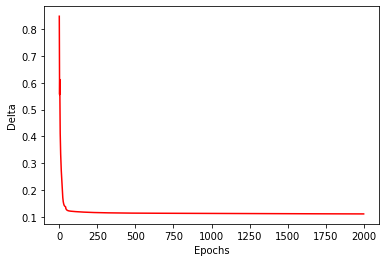

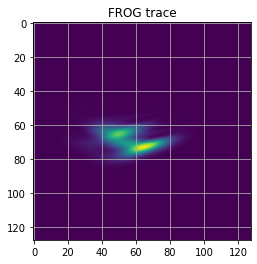

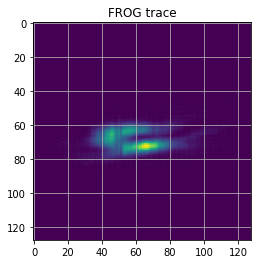

In [170]:
T= 1000
min_t = 0
min_i = 0
min_j = 0
min_frog = 6
for i in range (500, 1500, 50):
    x = FROGs(T,T,i0,A,f0,a,a2,a3,f1, tau1, tau2 )[1]
    if(x < min_frog):
        x = min_frog
        min_t = T
for i in range(0,3200, 50):
    for j in range(0,2500,50):
        x = FROGs(T,T,i0,A,f0,a,a2,a3,f1, i, j)[1]
        if(x < min_frog):
            x = min_frog
            min_i = i
            min_j = j
print(min_t, min_i, min_j)
gradient_d(min_t, i0, A, f0, a, a2, a3, f1, min_i, min_j)
FROG_trace_plot(original_trace)

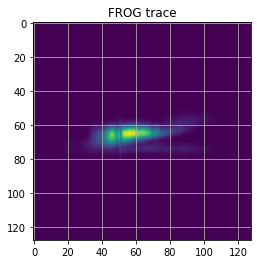

In [158]:
FROG_trace_plot(original_trace)

In [159]:
PLUS PI/2

SyntaxError: invalid syntax (<ipython-input-159-4e00026b82ff>, line 1)